## An application to connect to database with SQL ALchemy and analyze employee salaries. 

### Student Name : Radhika Balasubramaniam



#### import dependencies for the application

In [3]:
# Import SQLAlchemy `automap` and other dependencies here
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

# import matplotlib dependencies
import matplotlib
import matplotlib.pyplot as plt
import matplotlib._color_data as mcd
import matplotlib.ticker as ticker

# import pandas dependencies
import pandas as pd
 

#### Create Database Connection

In [59]:
# get connection string from the config file
from config import connection_string

# create the engine object with connection string
engine = create_engine(connection_string)

#establish the connection
connection = engine.connect()


#### Inspect engine for table names

In [5]:
# get the table names from the engine.
inspector = inspect(engine)
inspector.get_table_names()

['title', 'employee', 'dept_emp', 'department', 'dept_manager', 'salary']

#### Reflect Database into ORM classes

In [6]:
# build the relationships from the database
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['title', 'employee', 'department', 'salary']

#### Establish a communication session with the engine

In [8]:
session = Session(bind=engine)

#### Map Employee, Title, Salary class

In [13]:
Employee = Base.classes.employee
Salary = Base.classes.salary
Title = Base.classes.title

#### Retrieve the salary values from the Salary Table

In [60]:
salaries = pd.read_sql(session.query(Salary.salary).statement, engine)

salaries.head()

,salary
0,60117.0
1,65828.0
2,40006.0
3,40054.0
4,78228.0


#### Plot the histogram for the salaries

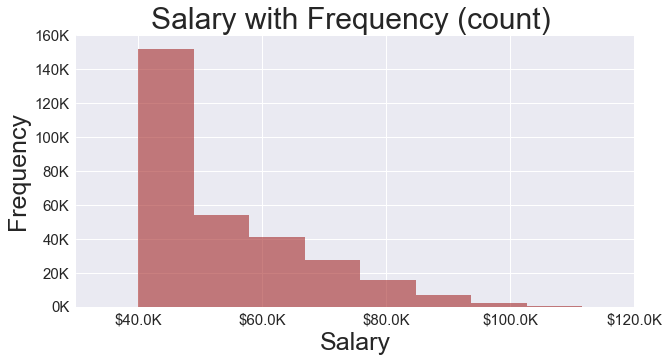

In [94]:
# plot histogram
plt.figure(figsize=(10,5))
plt.hist(salaries['salary'], color='brown', alpha=0.6)

# add tick labels for x-axis and set x limits
locs, labels = plt.xticks() 
xTickLabels =('$' + str(float(x/1000.0)) + 'K' for x in locs)
plt.xticks(locs,xTickLabels, fontsize=15 )
plt.xlim(30000, 120000)

# add ytick labels
ylocs, ylabels = plt.yticks() 
yTickLabels =(str(int(x/1000)) + 'K' for x in ylocs)
plt.yticks(ylocs,yTickLabels, fontsize=15 )

# add x-axis, y-axis labels
plt.xlabel('Salary', fontsize=25)
plt.ylabel('Frequency',fontsize=25)
#add title
plt.title("Salary with Frequency (count) ", fontsize=30)
plt.show()


#### Join Employee, Title, Salary tables and get salary averages by title

In [53]:

# join Employee, title, salary table, calculate average salary group by titles and convert them to data frame.
results =  pd.read_sql(session.query(Title.title, func.avg(Salary.salary).label('average'))\
                    .join(Employee, Employee.emp_title_id == Title.title_id)\
                    .join(Salary, Salary.emp_no == Employee.emp_no).group_by(Title.title).statement, engine)

# dynamically build colors for each title
colors = []
i = 1

# reference :- https://matplotlib.org/3.3.2/tutorials/colors/colors.html
overlap = {name for name in mcd.CSS4_COLORS
           if "xkcd:" + name in mcd.XKCD_COLORS}

for j, n in enumerate(sorted(overlap, reverse=True)):
    cn = mcd.CSS4_COLORS[n]
    colors.append(cn)
    # stop if the colors are picked for the titles in results
    if (i >= results['title'].count()):
        break;
    else:
       i += 1

# add colors to each title
results["Color"] = colors

#Set Index to title - ONLY RUN ONCE
results = results.set_index("title")


#### Bar Graph Average Salary By Title

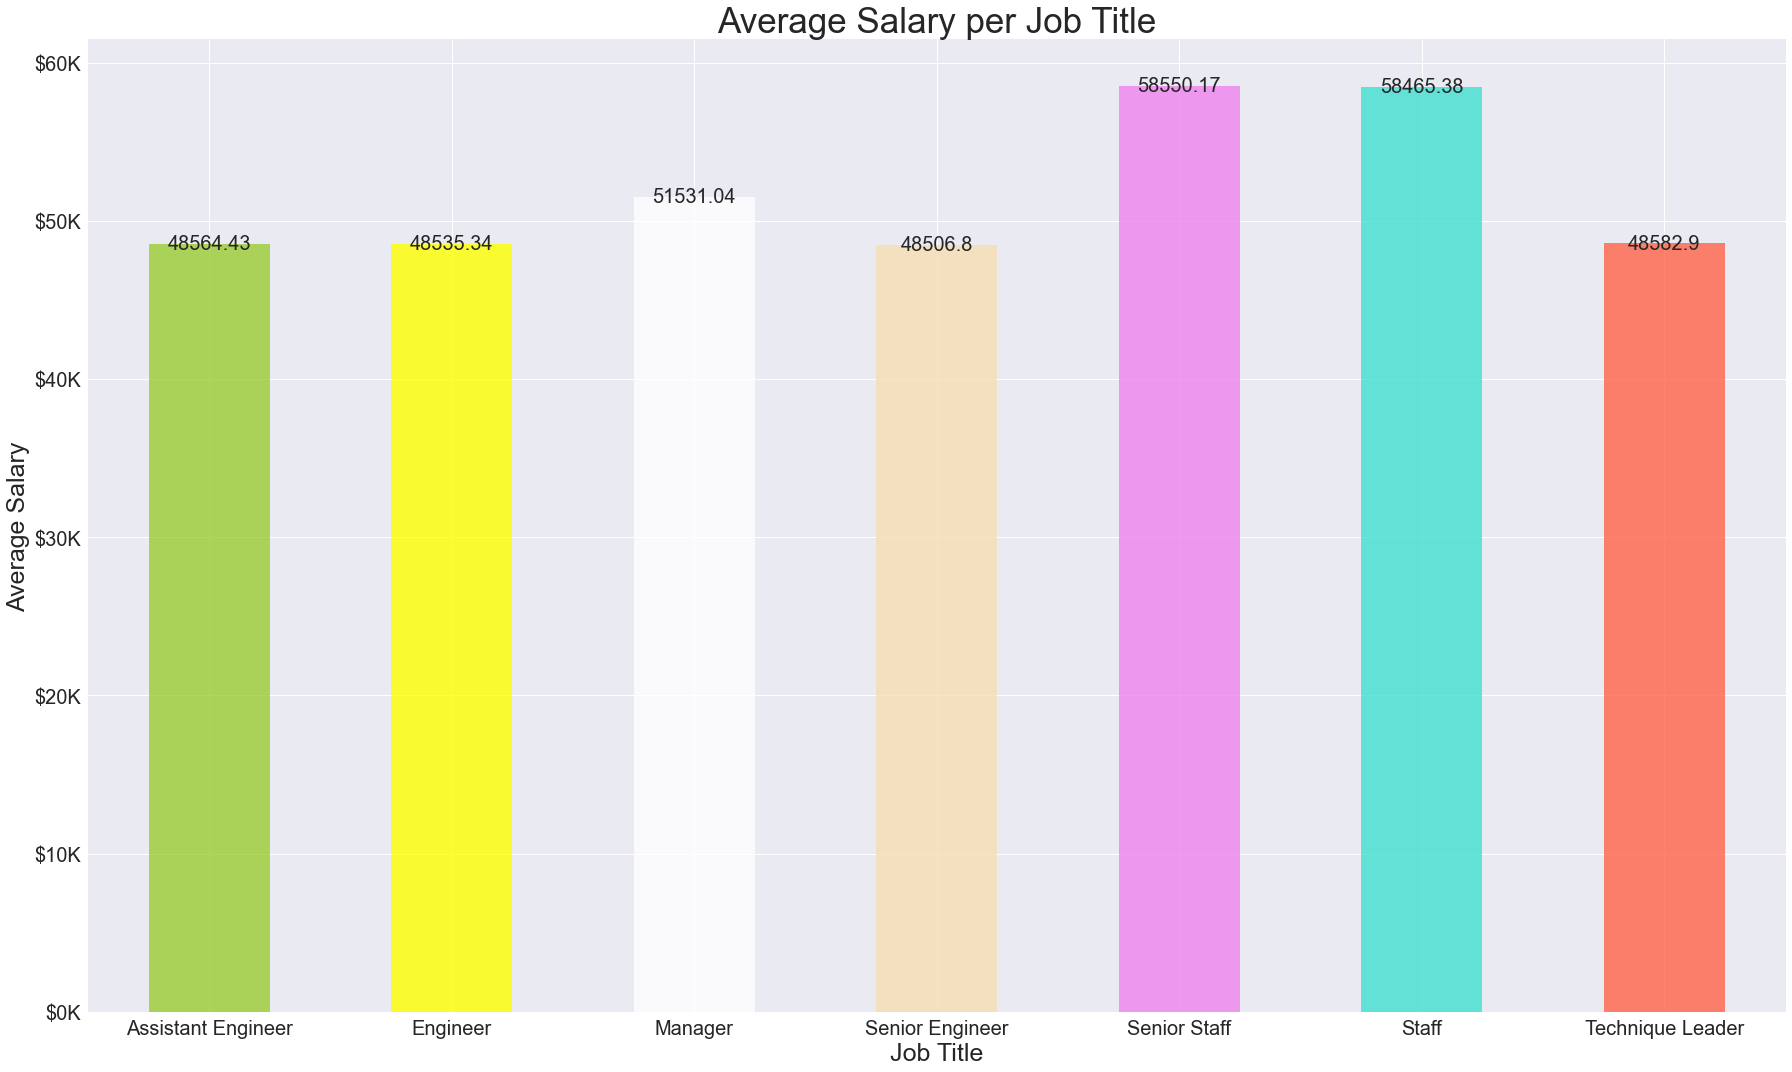

In [90]:

# build bar chart for the avaerage salary
plt.figure(figsize=(25,15))

# plot the bar chart
ax = results["average"].plot(kind="bar", color=results["Color"], alpha=.8,align="center",rot=0)

# plot ylabel ticks and xlabel ticks
ylabels = ['${:,.0f}'.format(x/1000.0) + 'K' for x in ax.get_yticks()]

# reference material : - https://matplotlib.org/3.2.1/gallery/ticks_and_spines/tick-formatters.html

ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(ylabels))

# set font size for the chart
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# add values to bar charts
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    # The width of the bar is the data value and can used as the label
    label_text = f"{round(height,2)}"  # f'{height:.2f}' if you have decimal values as labels
    label_x = x + width / 2
    label_y = y + height + 1
    ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=20)

# add xlabel, ylabel, title
plt.xlabel("Job Title",fontsize=25)
plt.ylabel("Average Salary",fontsize=25)
plt.title("Average Salary per Job Title", fontsize=35)

#show the plot
plt.tight_layout()
plt.show()
